In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
# change directory to the root of the project
from os import chdir

chdir("../..")


In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import pymannkendall as mk

from shapely.geometry import Point
from sklearn.linear_model import LinearRegression


In [4]:
station_id = 330020
year = 2022


In [5]:
# ingestor component output
input_data = pd.read_parquet(
    f"data/input/stations/{station_id}/daily_temp_history",
)
input_data


,min_temp,max_temp,mean_temp,cond_mean_temp,hourly_data_count,00_temp,12_temp,min_temp_date,max_temp_date,process_date
date,,,,,,,,,,
1950-01-01,NaN,NaN,22.8,NaN,3.0,NaN,NaN,NaN,NaN,NaN
1950-01-02,NaN,NaN,20.9,NaN,3.0,NaN,NaN,NaN,NaN,NaN
1950-01-03,NaN,NaN,20.3,NaN,3.0,NaN,NaN,NaN,NaN,NaN
1950-01-04,NaN,NaN,22.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN
1950-01-05,NaN,NaN,22.4,NaN,3.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-09-15,7.3,26.3,15.5,15.5,24.0,19.1,8.7,2023.0,2023.0,NaN
2023-09-16,7.6,21.6,14.6,14.6,24.0,13.4,8.7,2023.0,2023.0,NaN
2023-09-17,9.9,11.7,11.0,11.0,24.0,8.8,10.3,2023.0,2023.0,NaN


In [6]:
# preprocessor component output
preprocessed_data = pd.read_parquet(
    f"data/output/stations/{station_id}/{year}_daily_temp_with_threshold.parquet",
)
preprocessed_data


,max_temp,90_percentile,90_percentile_adj,above_threshold
date,,,,
2022-01-01,29.9,33.30,33.278560,0
2022-01-02,31.0,32.55,33.294753,0
2022-01-03,32.6,32.90,33.309223,0
2022-01-04,32.4,33.50,33.321965,0
2022-01-05,32.3,32.30,33.332975,0
...,...,...,...,...
2022-12-27,30.5,32.60,33.165478,0
2022-12-28,32.2,32.50,33.190630,0
2022-12-29,34.4,32.75,33.214089,1


In [7]:
# reporter component output
report_data = pd.read_parquet(
    f"data/reporting/stations/{station_id}/year_stats/{year}_stats.parquet",
)
report_data


,start,end,duration,mean_temp,min_temp,max_temp,sum_intensity
0,2022-12-04,2022-12-13,10,33.500000,32.5,35.7,18.35
1,2022-11-21,2022-11-23,3,32.466667,32.2,33.0,4.35
2,2022-11-15,2022-11-18,4,32.100000,31.2,33.5,5.90
3,2022-10-31,2022-11-02,3,31.066667,29.6,32.5,6.70
4,2022-09-03,2022-09-06,4,27.275000,26.2,29.2,9.60
5,2022-08-19,2022-08-21,3,25.333333,23.3,27.3,6.50
6,2022-04-04,2022-04-08,5,29.560000,28.7,30.4,3.60


In [19]:
# TODO: freq. e intensidad por año

# intensity = sum(real_temp - 90_percentile) (also, min, max, sum)
agg_report_data = pd.read_parquet(
    f"data/reporting/stations/{station_id}/agg_year_stats/default",
)
# TODO: handle 'std_hw_intensity' NaN values

agg_report_data


,n_hw,mean_hw_temp,max_hw_temp,min_hw_temp,mean_hw_duration,max_hw_duration,min_hw_duration,hw_intensity,mean_hw_intensity,std_hw_intensity,max_hw_intensity,min_hw_intensity,hw_days,ratio_hw_per_day
year,,,,,,,,,,,,,,
1981,3,27.164444,29.5,24.6,3.666667,5,3,13.95,4.650000,4.521062,9.85,1.65,11.0,0.008219
1982,1,24.266667,26.8,22.8,3.000000,3,3,3.45,3.450000,NaN,3.45,3.45,3.0,0.002740
1983,2,29.291667,31.8,27.4,4.500000,6,3,14.60,7.300000,3.818377,10.00,4.60,9.0,0.005479
1984,5,26.755000,31.4,22.2,3.200000,4,3,20.10,4.020000,2.378445,7.95,1.95,16.0,0.013699
1985,1,23.066667,23.6,22.5,3.000000,3,3,5.25,5.250000,NaN,5.25,5.25,3.0,0.002740
1986,5,28.181476,34.2,21.8,4.800000,7,3,38.95,7.790000,5.783533,17.70,3.60,24.0,0.013699
1987,4,27.116667,31.4,22.2,3.250000,4,3,26.50,6.625000,4.706467,10.85,1.95,13.0,0.010959
1988,3,29.505556,32.6,27.0,3.666667,4,3,12.80,4.266667,2.648742,7.20,2.05,11.0,0.008219
1989,3,30.788889,33.4,28.2,3.000000,3,3,11.00,3.666667,3.192308,7.35,1.70,9.0,0.008219


In [20]:
col_name_map = {
    "n_hw": "Number of Heatwaves",
    "mean_hw_temp": "Mean Heatwave Temperature",
    "max_hw_temp": "Max Heatwave Temperature",
    "min_hw_temp": "Min Heatwave Temperature",
    "mean_hw_duration": "Mean Heatwave Duration",
    "max_hw_duration": "Max Heatwave Duration",
    "min_hw_duration": "Min Heatwave Duration",
    "hw_intensity": "Heatwave Intensity",
    "mean_hw_intensity": "Mean Heatwave Intensity",
    "std_hw_intensity": "Std Heatwave Intensity",
    "max_hw_intensity": "Max Heatwave Intensity",
    "min_hw_intensity": "Min Heatwave Intensity",
    "hw_days": "Heatwave Days",
    "ratio_hw_per_day": "Ratio Heatwaves per Day",
}


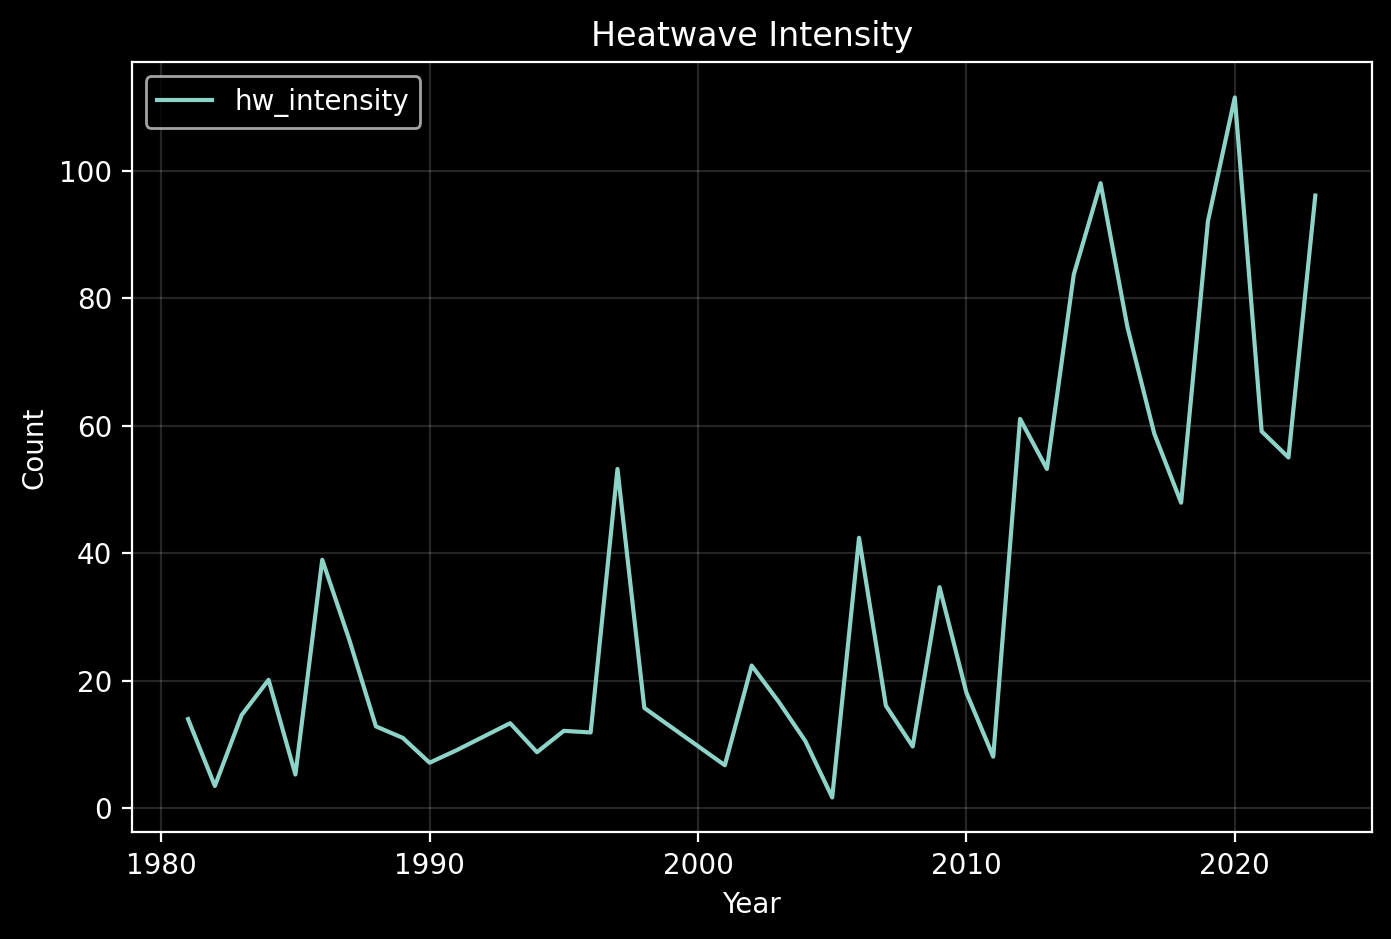

In [22]:
col = "hw_intensity"
agg_report_data.reset_index().plot(x="year", y=col)

plt.xlabel("Year")
plt.ylabel("Count")
plt.title(col_name_map[col])
plt.grid(
    visible=True,
    alpha=0.15,
)

plt.show()


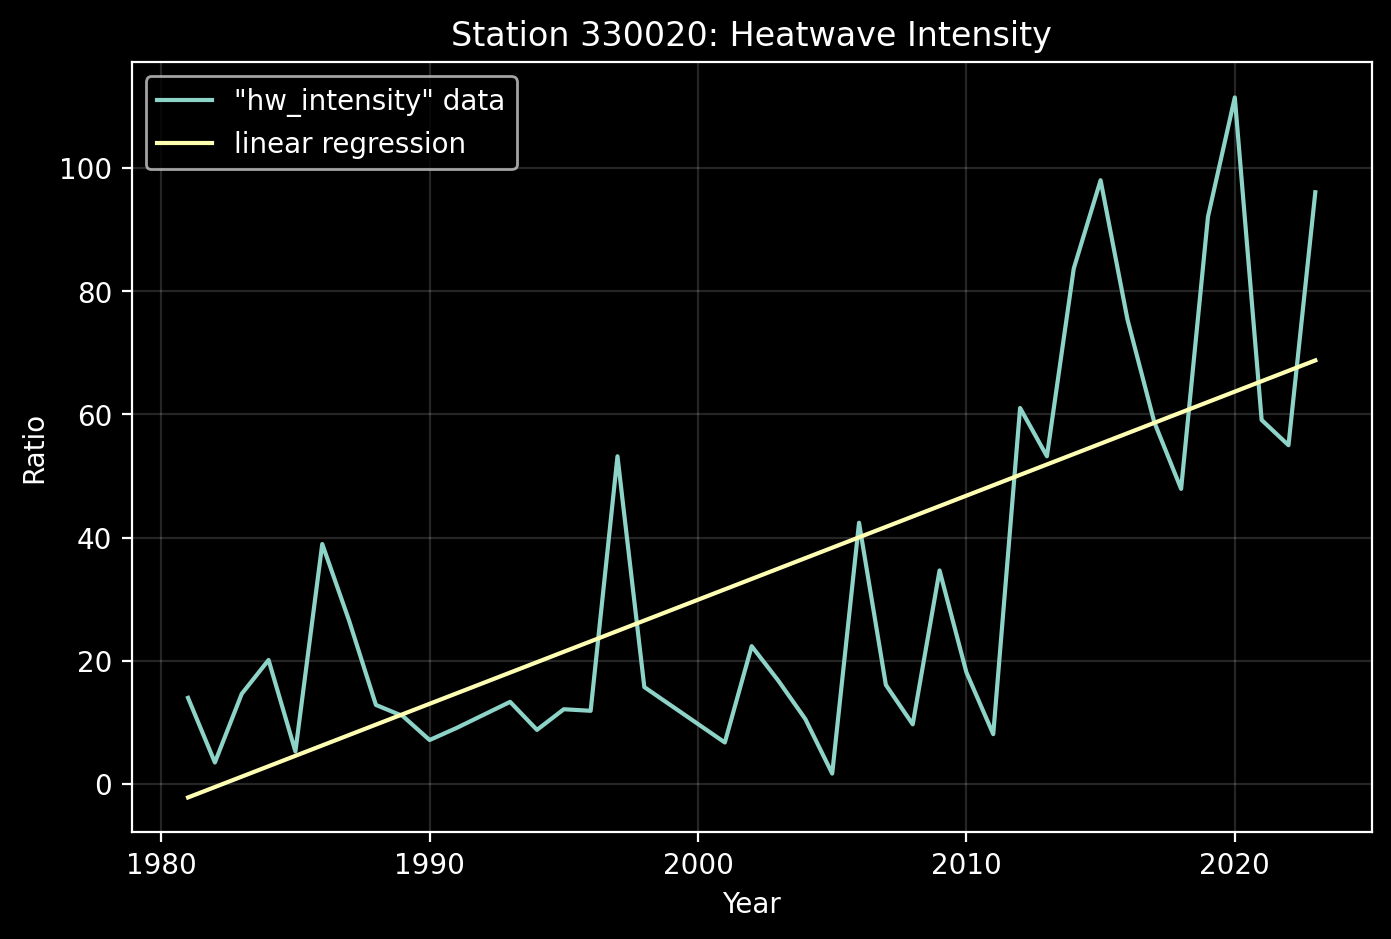

mk_test,value
output,
trend,increasing
h,True
p,0.000026
z,4.206023
Tau,0.464103
s,362.0
var_s,7366.666667
slope,1.56792
intercept,-13.174432


In [30]:
# simple linear fit to justify up-trend
# cols = ["mean_hw_temp", "hw_intensity", "n_hw", "ratio_hw_per_day"]
col = "hw_intensity"
data = agg_report_data[[col]]

# fit a linear regression model
model = LinearRegression(n_jobs=-1)
model.fit(data.index.values.reshape(-1, 1), data[col].values.reshape(-1, 1))

# get trend
trend = model.coef_[0][0]

# get prediction
pred = model.predict(data.index.values.reshape(-1, 1))

# plot
plt.plot(data.index, data[col], label=f'"{col}" data')
plt.plot(data.index, pred, label="linear regression")
plt.legend()

plt.xlabel("Year")
plt.ylabel("Ratio")
plt.title(f"Station {station_id}: {col_name_map[col]}")
plt.grid(
    visible=True,
    alpha=0.15,
)

plt.show()


# Mann-Kendall test implementation for trend detection
# M-K test skeleton df
index = ["trend", "h", "p", "z", "Tau", "s", "var_s", "slope", "intercept"]
mk_df = pd.DataFrame(
    index=pd.Index(index, name="output"), columns=pd.Index(["value"], name="mk_test")
)

# fill df values
mk_df["value"] = mk.original_test(data, alpha=0.05)

mk_df


## Chile climate seasons

- Traditional point of view:

| season | start  |  end   |
| :----: | :----: | :----: |
| summer | Dec 21 | Mar 20 |
| autumn | Mar 20 | Jun 21 |
| winter | Jun 21 | Sep 21 |
| spring | Sep 21 | Dec 21 |

-


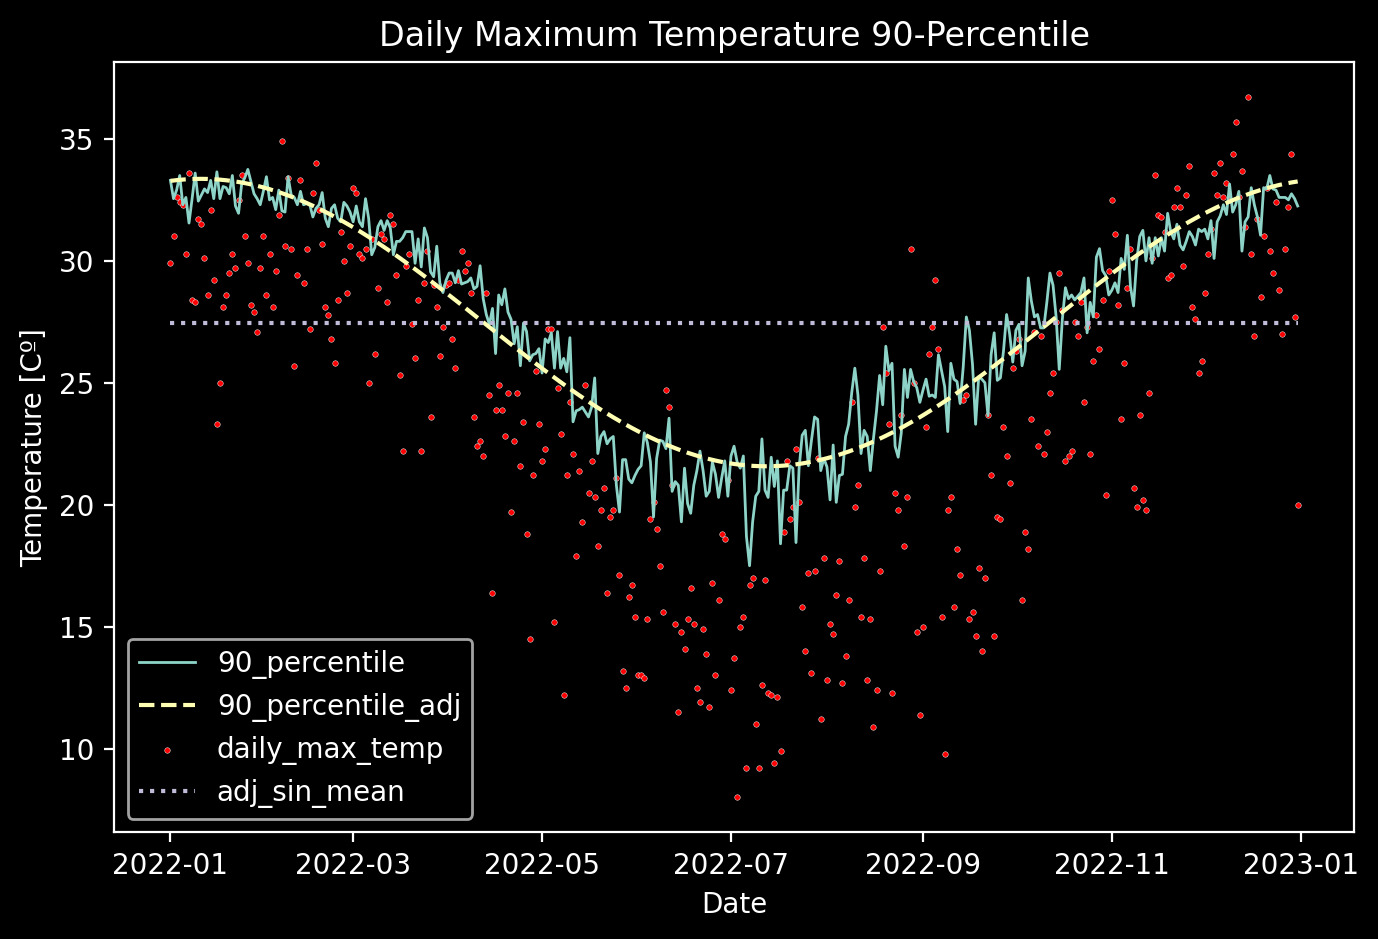

27.466301370159876

In [10]:
# plot 2022 year example with:
# - daily maximum temperature
# - 90-percentile (historic)
# - 90-percentile (historic) adjusted with sin function
# - adj sin function mean, that separates summer from winter data

import seaborn as sns


sin_mean = preprocessed_data["90_percentile_adj"].mean()

sns.lineplot(preprocessed_data, y="90_percentile", x="date", label="90_percentile", lw=1)
sns.lineplot(
    preprocessed_data, y="90_percentile_adj", x="date", label="90_percentile_adj", lw=1.5, ls="--"
)
sns.scatterplot(preprocessed_data, y="max_temp", x="date", label="daily_max_temp", color="red", s=4)
sns.lineplot(preprocessed_data, y=sin_mean, x="date", label="adj_sin_mean", lw=1.5, ls=":")

plt.xlabel("Date")
plt.ylabel("Temperature [Cº]")
plt.title("Daily Maximum Temperature 90-Percentile")
plt.show()

sin_mean


In [11]:
# get two dates from different months with the smallest difference between the 90th
# percentile and the sin mean
ans = (preprocessed_data[["90_percentile_adj"]] - sin_mean).abs()
ans.loc[:, "month"] = ans.index.month

min_monthly_grouped_diffs = ans.groupby(["month"], as_index=True).min().reset_index(drop=True)
min_monthly_diffs = (
    ans.reset_index()
    .merge(min_monthly_grouped_diffs, on="90_percentile_adj")
    .drop(columns=["month"])
    .set_index("date")
    .sort_values("90_percentile_adj")
)
dt1, dt2 = min_monthly_diffs.head(2).index.tolist()

dt1, dt2


(Timestamp('2022-04-12 00:00:00'), Timestamp('2022-10-12 00:00:00'))

In [12]:
# seasonal data
summer_data = preprocessed_data[(preprocessed_data.index <= dt1) | (dt2 <= preprocessed_data.index)]
winter_data = preprocessed_data[(dt1 < preprocessed_data.index) & (preprocessed_data.index < dt2)]

summer_data.shape, winter_data.shape


((183, 4), (182, 4))

In [18]:
# compute yearly stat for summer/winter season
from hw_predictor.components.reporter.src.meteochile import (
    _compute_year_stats,
    _compute_agg_year_stats,
)

winter_ystats = _compute_year_stats(winter_data)
summer_ystats = _compute_year_stats(summer_data)

winter_agg_ystats = _compute_agg_year_stats(winter_ystats)
summer_agg_ystats = _compute_agg_year_stats(summer_ystats)

# winter_ystats
summer_ystats


,start,end,duration,mean_temp,min_temp,max_temp,sum_intensity
0,2022-12-04,2022-12-13,10,33.500000,32.5,35.7,18.35
1,2022-11-21,2022-11-23,3,32.466667,32.2,33.0,4.35
2,2022-11-15,2022-11-18,4,32.100000,31.2,33.5,5.90
3,2022-10-31,2022-11-02,3,31.066667,29.6,32.5,6.70
4,2022-04-04,2022-04-08,5,29.560000,28.7,30.4,3.60


In [25]:
# winter_agg_ystats
summer_agg_ystats


,n_hw,mean_hw_temp,max_hw_temp,min_hw_temp,mean_hw_duration,max_hw_duration,min_hw_duration,hw_intensity,mean_hw_intensity,std_hw_intensity,max_hw_intensity,min_hw_intensity,hw_days,ratio_hw_per_day
year,,,,,,,,,,,,,,
2022,5,31.738667,35.7,28.7,5.0,10,3,38.9,7.78,6.034546,18.35,3.6,25.0,0.013699


In [27]:
winter_agg_ystats


,n_hw,mean_hw_temp,max_hw_temp,min_hw_temp,mean_hw_duration,max_hw_duration,min_hw_duration,hw_intensity,mean_hw_intensity,std_hw_intensity,max_hw_intensity,min_hw_intensity,hw_days,ratio_hw_per_day
year,,,,,,,,,,,,,,
2022,2,26.304167,29.2,23.3,3.5,4,3,16.1,8.05,2.192031,9.6,6.5,7.0,0.005479


In [97]:
# metadata stations info
stations = pd.read_parquet("data/input/stations/metadata.parquet")

# heatwaves reasearch stations
hw_stations = pd.read_parquet("data/input/stations/hw_research_stations.parquet")

# join -> (34 - 1) hw_research stations
hw_stations = stations.join(hw_stations[["min_year", "max_year"]], how="right")

# drop bad stations
bad_stations = [
    270002,  # missing data
    950001,  # south
]
for station_id in bad_stations:
    hw_stations.drop(station_id, inplace=True)

hw_stations


,WMO_code,ICAO_code,name,latitude,longitude,altitude,state_id,geographic_zone_id,data_link,min_year,max_year
national_code,,,,,,,,,,,
180005,85406.0,SCAR,"Chacalluta, Arica Ap.",-18.35555,-70.34028,50.0,15.0,1.0,https://climatologia.meteochile.gob.cl/applica...,1955.0,2023.0
200006,85418.0,SCDA,Diego Aracena Iquique Ap.,-20.54917,-70.18111,48.0,1.0,1.0,https://climatologia.meteochile.gob.cl/applica...,1981.0,2023.0
220002,85432.0,SCCF,"El Loa, Calama Ad.",-22.49806,-68.89250,2321.0,2.0,2.0,https://climatologia.meteochile.gob.cl/applica...,1965.0,2023.0
230001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950.0,2023.0
270001,85469.0,SCIP,Mataveri Isla de Pascua Ap.,-27.15889,-109.43250,44.0,5.0,1.0,https://climatologia.meteochile.gob.cl/applica...,1954.0,2023.0
290004,85488.0,SCSE,"La Florida, La Serena Ad.",-29.91444,-71.20667,137.0,4.0,3.0,https://climatologia.meteochile.gob.cl/applica...,1954.0,2023.0
300046,85502.0,,"Vicuña, Parque Los Pimientos",-30.03361,-70.69722,642.0,4.0,5.0,https://climatologia.meteochile.gob.cl/applica...,2017.0,2023.0
310024,85523.0,,Liceo Samuel Román Rojas (Combarbalá),-31.18805,-70.99889,936.0,4.0,2.0,https://climatologia.meteochile.gob.cl/applica...,2011.0,2023.0
320019,85537.0,,San Felipe Escuela Agrícola,-32.75528,-70.70694,662.0,5.0,5.0,https://climatologia.meteochile.gob.cl/applica...,2019.0,2023.0
